# MLSP 2014 Schizophrenia Classification Challenge

`Drew Wilimitis`<br>

data source: https://www.kaggle.com/c/mlsp-2014-mri/data

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/100325_RS88UH_11_qc.gif/330px-100325_RS88UH_11_qc.gif)

**Overview & fMRI features**:<br>
- 86 total patients labeled 0 (healthy) or 1 (patient has schizophrenia) <br>
- Each individual has 379 Functional Network Connectivity (FNC) features, which are correlation values between 28 brain regions/maps of interest (ROI) <br>
- We consider the 28 brain regions as nodes in a subject's connectivity graph, and we insert edge(region A, region B) if the corresponding FNC (correlation) is greater than some threshhold <br>
- Each of the subjects has a unique network connectivity graph which we analyze in order to detect the presence of schizophrenia

**Hyperbolic Geometry Approach:** <br>

Given the extent to which real world networks often exhibit latent hyperbolic geometry, along with the plausibility of hierarchical relationships existing within the brain, we naturally attempt to investigate hyperbolic representations of our functional connectome data. 

We perform the following steps:<br>
1. Prepare unweighted, undirected graphs for each subject with nodes as brain regions. <br>
2. Apply Coalescent Embedding algorithm to embed each connectivity graph in the Poincare disk <br>
3. Compute new pairwise connectivity features based on hyperbolic distances in the embedding space <br>
4. Train classifier on hyperbolic features and compare predictive capacity to baseline, FNC correlation features

### Import libraries and load data

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os

# import modules within repository

sys.path.append(r'C:\Users\Cole S Baker\Desktop\Thesis\Thesis\hgcn\hyperbolic_learning_master\hyperbolic_kmeans')  # path to hkmeans folder
sys.path.append(r'C:\Users\Cole S Baker\Desktop\Thesis\Thesis\hgcn\hyperbolic_learning_master\utils') # path to utils folder
sys.path.append(r'C:\Users\Cole S Baker\Desktop\Thesis\Thesis\hgcn') # path to utils folder
from utils import *
from hkmeans import HyperbolicKMeans, plot_clusters

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [8]:
# load training data and labels
train_data = pd.read_csv('train/train_fnc.csv')
train_data.head()
train_data.shape
train_labels = pd.read_csv('train/train_labels.csv')
train_labels.shape

# load mappings between region numbers and independent component numbers
map_functional = pd.read_csv('add_info/comp_ind_fmri.csv', index_col=None)
map_functional = map_functional['fMRI_comp_ind'].to_dict() # index to brain region num
map_functional_r = {v: k for k, v in map_functional.items()} # brain region num to index
mapping = pd.read_csv('add_info/rs_fmri_fnc_mapping.csv')
mapping.head()
mapping.shape

,Id,FNC1,FNC2,FNC3,FNC4,FNC5,FNC6,FNC7,FNC8,FNC9,...,FNC369,FNC370,FNC371,FNC372,FNC373,FNC374,FNC375,FNC376,FNC377,FNC378
0,120873,0.34312,0.045761,-0.13112,0.15034,0.18082,0.289160,0.069545,-0.052489,0.124000,...,0.18743,0.163770,0.17686,0.074728,0.148600,0.343230,0.17565,0.52035,0.030613,0.30774
1,135376,0.28790,0.102570,-0.32343,-0.22776,0.12328,0.367020,-0.084040,0.038793,-0.006287,...,0.59834,-0.477880,0.26634,0.582940,-0.041272,0.630050,0.70314,0.36383,-0.207880,0.64138
2,139149,0.24585,0.216620,-0.12468,-0.35380,0.16150,-0.002032,-0.133020,-0.035222,0.259040,...,0.22866,-0.000816,0.25860,0.280450,-0.644640,0.332440,0.87074,-0.10973,-0.679160,0.32316
3,146791,0.42090,0.331380,0.24453,0.17167,0.59223,0.431050,0.280290,0.289620,0.356800,...,0.42881,0.711570,0.56593,0.248560,0.153860,0.093171,0.62556,0.60391,-0.058301,0.10779
4,153870,-0.14621,-0.468630,-0.52880,-0.50381,-0.51052,-0.029113,-0.015192,0.360170,0.005944,...,0.41688,-0.435600,0.32104,0.392960,-0.842430,0.425080,0.86509,-0.31281,-0.829640,0.24307


(86, 379)

(86, 2)

,FNC,mapA,mapB
0,1,21,17
1,2,21,7
2,3,21,23
3,4,21,24
4,5,21,38


(378, 3)

Each of the 28 brain regions belongs to one of the following larger brain networks: Basal Ganglia, Auditory, Sensorimotor, Visual, Default-Mode, Attention, and Frontal Networks.

In [9]:
# get anatomical network labels for the 28 fmri component regions
rs_roi_maps = pd.read_table('add_info/RSN_comp_labels.txt', header=None).to_dict()
rs_net_labels = rs_roi_maps[0]
labels = []
vals = []
for k,v in rs_roi_maps[1].items():
    vals += v.split(', ')
    labels += list(np.repeat(k, len(v.split(', '))))
rs_net_df = pd.DataFrame(np.hstack((np.array(vals).reshape(-1,1),np.array(labels).reshape(-1,1))))
rs_net_df.columns = ['brain_map', 'label']
rs_net_df['brain_map'] = rs_net_df['brain_map'].astype('int')
rs_net_df['label'] = rs_net_df['label'].astype('int')
label_dict = dict(zip(rs_net_df.brain_map.values, rs_net_df.label.values))
rs_net_labels

{0: 'BG', 1: 'AUD', 2: 'MOT', 3: 'VIS', 4: 'DMN', 5: 'ATN', 6: 'FRONT'}

We now fit a basic logistic regression classifier and evaluate baseline performance with FNC features.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_predict
X = train_data
y = train_labels.Class.values
pred = cross_val_predict(LogisticRegression(class_weight='balanced'), X, y, cv=5)
baseline_f1 = f1_score(y, pred, average='macro')
print(classification_report(y, pred))
print(accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.54      0.46      0.49        46
           1       0.47      0.55      0.51        40

    accuracy                           0.50        86
   macro avg       0.50      0.50      0.50        86
weighted avg       0.51      0.50      0.50        86

0.5


### Define graphs for each functional connectome
After building graph structures from our input training data, we explore the mean connectivity graphs for each subject group. 

In [11]:
# source for following connectome preprocessing methods: https://github.com/geomstats/applications/tree/master/brain_connectome
# create graphs from FNC data
N_NODES = 28
CORR_THRESH = 0.1
N_GRAPHS = 86

# create matrix with connectivity values
def create_connectome(data, graph_id, mapping):
    u = np.zeros((N_NODES, N_NODES))
    n_edges = mapping.shape[0]
    for i in range(n_edges):
        e0, e1 = (mapping.iloc[i]['mapA'], mapping.iloc[i]['mapB'])
        region0, region1 = map_functional_r[e0], map_functional_r[e1]
        u[region0, region1] = data.iloc[graph_id][i]
        u = np.multiply(u, (u > CORR_THRESH))
    return np.abs(u + u.T)

# create connectome matrix for each subject
graph_data = [None] * N_GRAPHS
graph_labels = np.zeros(N_GRAPHS)
for graph_id in range(N_GRAPHS):
    graph_data[graph_id] = create_connectome(train_data, graph_id, mapping)
    graph_labels[graph_id] = int(train_labels.loc[train_data.index[graph_id], 'Class'])
graph_data = np.array(graph_data)
graph_data.shape
graph_labels.shape

(86, 28, 28)

(86,)

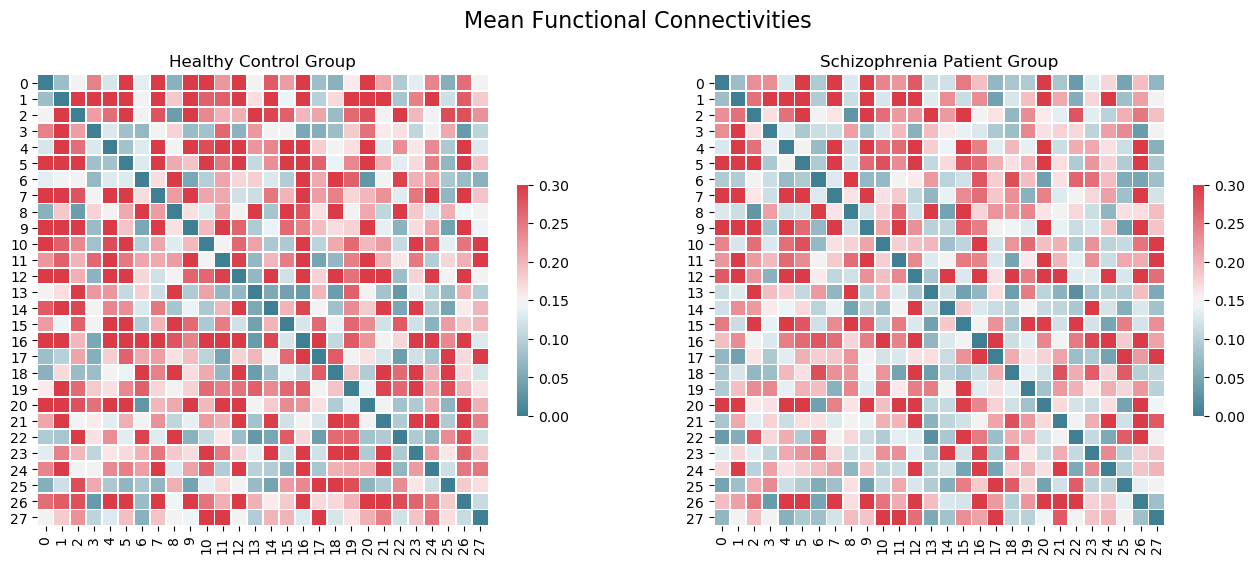

In [464]:
# plot mean group correlations
plt.style.use('default')
plt.figure(figsize=((16,6)))
plt.subplot(121)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(np.mean(graph_data[(graph_labels == 0)], axis=0), cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Healthy Control Group', size=12)
plt.subplot(122)
sns.heatmap(np.mean(graph_data[(graph_labels == 1)], axis=0), cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title('Schizophrenia Patient Group')
plt.suptitle('Mean Functional Connectivities', size=16)
plt.show();

We now take the mean connectivity matrix for each group and then define unweighted, undirected graph networks. The mean connectivity networks are then input to the coalescent embedding algorithm, which returns a two dimensional, hyperbolic embedding.  

In [12]:
# get average connectivities per group
avg_conn_0 = np.mean(graph_data[(graph_labels == 0)], axis=0)
avg_conn_1 = np.mean(graph_data[(graph_labels == 1)], axis=0)

# need unweighted, undirected graph network
import networkx as nx
def get_edges(C):
    edges = []
    for i in range(len(C)):
        for j in range(i, len(C)):
            if C[i, j] > 0:
                edges.append([i, j])
    return edges

# get edges and prepare input to embedding method
adj_conn_0 = np.where(avg_conn_0 > 0.2, 1, 0)

# healthy control
df_conn_0 = pd.DataFrame(np.array(get_edges(adj_conn_0)), columns = ['u', 'v'])
df_conn_0.shape
df_conn_0.to_csv('mean_connectome_0.csv', index=False)
adj_conn_1 = np.where(avg_conn_1 > 0.2, 1, 0)

# schizophrenia patient group
df_conn_1 = pd.DataFrame(np.array(get_edges(adj_conn_1)), columns = ['u', 'v'])
df_conn_1.shape
df_conn_1.to_csv('mean_connectome_1.csv', index=False)

# create input graph df for each subject
for i in range(graph_data.shape[0]):
    # get edges and prepare input to embedding method
    adj_conn = np.where(graph_data[i] > 0.15, 1, 0)
    df_conn = pd.DataFrame(np.array(get_edges(adj_conn)), columns = ['u', 'v'])
    df_conn.to_csv('connectome_{}.csv'.format(i), index=False)

(189, 2)

(151, 2)

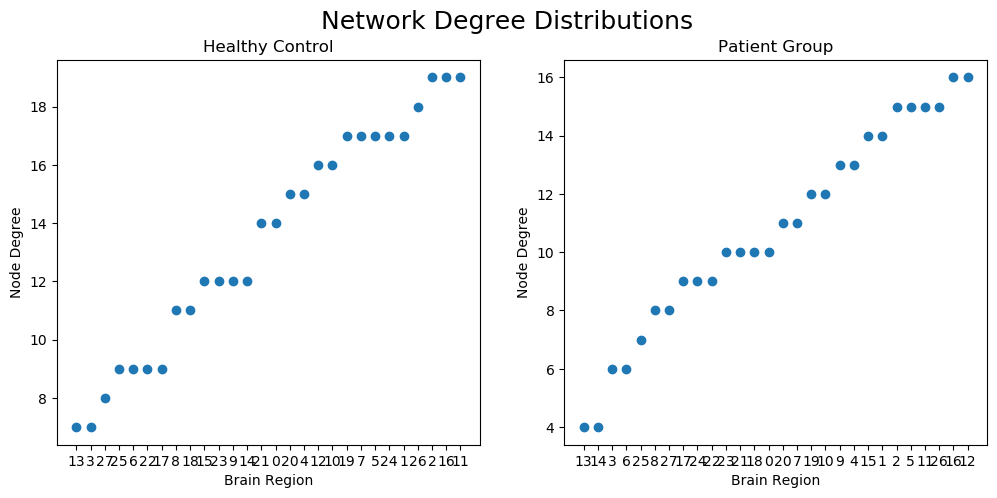

In [466]:
# plot degree distributions for each group
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(np.arange(0, 28, 1), np.sort(np.sum(adj_conn_0, axis=0)))
ax = plt.gca()
ax.set_xticks(np.arange(0, 28, 1))
ax.set_xticklabels([str(x) for x in np.argsort(np.sum(adj_conn_0, axis=0))]);
plt.xlabel('Brain Region')
plt.ylabel('Node Degree')
plt.title('Healthy Control')

plt.subplot(122)
plt.scatter(np.arange(0, 28, 1), np.sort(np.sum(adj_conn_1, axis=0)))
ax = plt.gca()
ax.set_xticks(np.arange(0, 28, 1))
ax.set_xticklabels([str(x) for x in np.argsort(np.sum(adj_conn_1, axis=0))]);
plt.xlabel('Brain Region')
plt.ylabel('Node Degree')
plt.title('Patient Group')
plt.suptitle('Network Degree Distributions', size=18)
plt.show();

### Embed graphs into 2-D hyperbolic space
The coalescent embedding algorithm that I use is provided by the following open source repository with an R implementation of the laplacian based method: https://github.com/galanisl/NetHypGeom/blob/master/R/labne_hm.R

In [13]:
def load_embedding(file):
    # read in embedding coordinates
    emb = pd.read_csv(file)
    # scale within poincare ball
    emb['r'] = emb.r / np.max(emb.r) - 1e-2
    # get cartesian coordinates
    x = []
    y = []
    for i in range(emb.shape[0]):
        x.append(emb.r[i]*np.cos(emb.theta[i]))
        y.append(emb.r[i]*np.sin(emb.theta[i]))
    emb['x'] = x
    emb['y'] = y
    emb['fmri_comp'] = emb.id.apply(lambda x: map_functional[x])
    emb['label'] = emb.fmri_comp.apply(lambda x: label_dict[x])
    return emb

def plot_embedding(emb, title=None, plot_edges=True):
    colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k']
    for i in range(len(emb0.label.unique())):
        plt.scatter(emb.loc[(emb.label == i), 'x'], emb.loc[(emb.label == i), 'y'], c=colors[i], s=150, label=rs_net_labels[i]);
    for i in range(emb.shape[0]):
        plt.text(emb.loc[(emb.id == i), 'x']+0.025, emb.loc[(emb.id == i), 'y']+0.05, str(i), size=14)
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    if plot_edges:
        edge_list_0 = get_edges(adj_conn_0)
        for i in range(len(edge_list_0)):
            x1 = emb.loc[(emb.iloc[:, 0] == edge_list_0[i][0]), ['x', 'y']].values[0]
            x2 = emb.loc[(emb.id == edge_list_0[i][1]), ['x', 'y']].values[0]
            _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.25)
    if title != None:
        plt.title(title, size=16)

I now plot the hyperbolic embedding for each group's mean connectivity network. 

AttributeError: 'DataFrame' object has no attribute 'r'

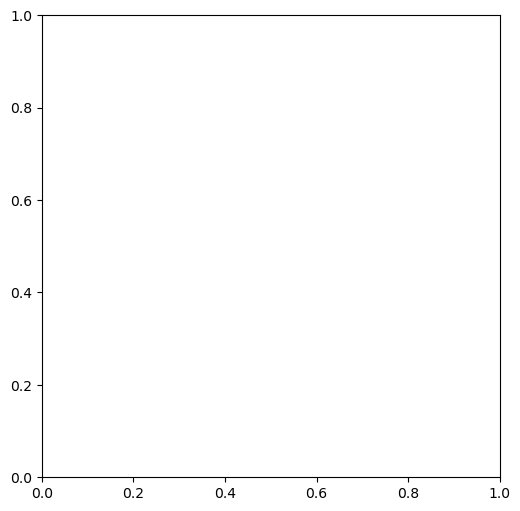

In [15]:
plt.figure(figsize=(13,6))
plt.style.use('default')
plt.subplot(121)
emb0 = load_embedding('mean_emb_0.csv')
plot_embedding(emb0, title='Healthy Control');
plt.subplot(122)
emb1 = load_embedding('mean_emb_1.csv')
plot_embedding(emb1, title='Patient Group');
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1, edgecolor='black');
plt.suptitle('Hyperbolic Connectome Embeddings', size=18);

In both groups, it seems that there are vaguely two distinct clusterings with the Attention and Default Mode networks forming one cluster and the Sensorimotor and Visual Networks forming the other partition. There's also some visual evidence of a weakly hierarchical structure in which the Frontal network seems to be located near the center of each space.<br>

It seems that the attention network, and to a lesser extent the default mode network, is more densely connected in the healthy group. Clustering metrics between and within these larger 7 networks could provide useful hyperbolic features for classification.<br>

A more extensive analysis of the relevant neurobiology and psychiatry would be crucial for this analysis, but is quite outside our scope here. <br>

### Engineering hyperbolic distance features

If the latent geometry of the functional connectome network is at all hyperbolic, then the distances in the embedding might provide more meaningful connectivity features. We find the pairwise hyperbolic distances between each of the nodes (brain regions) and compare between groups.

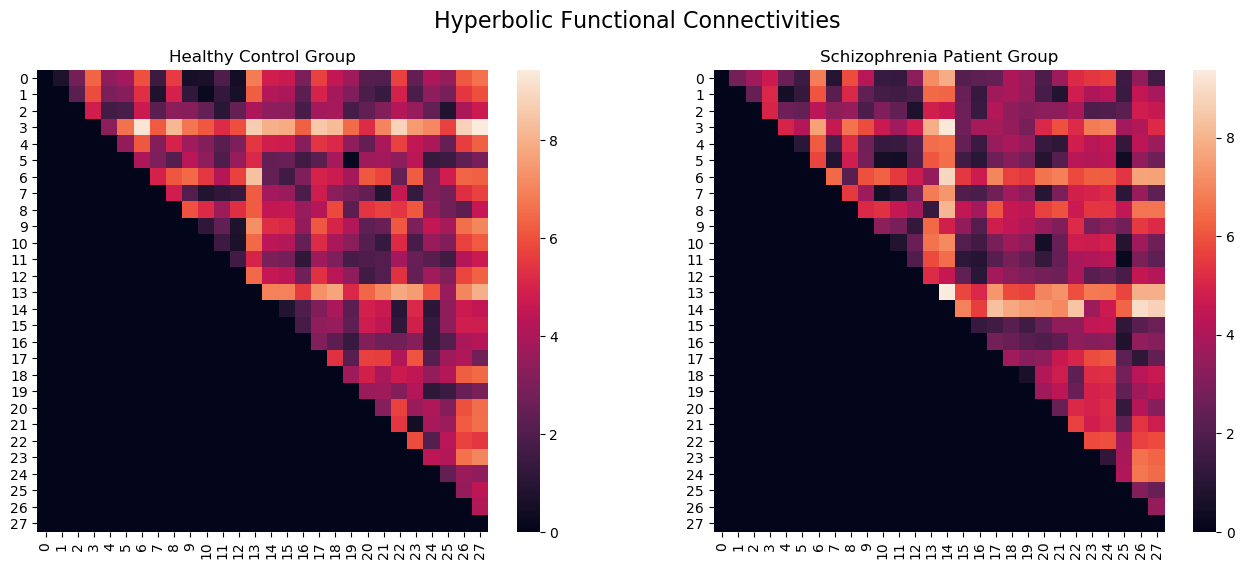

In [471]:
# get hyperbolic distance matrix
from utils import poincare_distances
D0 = poincare_distances(np.array(emb0[['x', 'y']]))
D1 = poincare_distances(np.array(emb1[['x', 'y']]))

# plot group hyperbolic distances
plt.figure(figsize=((16,6)))
plt.subplot(121)
sns.heatmap(D0)
plt.title('Healthy Control Group', size=12)
plt.subplot(122)
sns.heatmap(D1);
plt.title('Schizophrenia Patient Group')
plt.suptitle('Hyperbolic Functional Connectivities', size=16)
plt.show();

### Training model on hyperbolic features

In [408]:
hyp_train = []
# load the embeddings for each subject (row) in our training dataset 
for i in range(graph_data.shape[0]):
    emb = load_embedding('emb_' + str(i) + '.csv')
    D = poincare_distances(np.array(emb[['x', 'y']]))
    # only need upper triangular entries
    D_upper = []
    for j in range(D.shape[0]):
        for k in range(j+1, D.shape[0]):
            D_upper.append(D[j, k])
    hyp_train.append(np.array(D_upper))
hyp_train = np.array(hyp_train)
hyp_train.shape

(86, 378)

In [635]:
# evaluate cross validation metrics
X = hyp_train
y = train_labels.Class.values
pred = cross_val_predict(LogisticRegression(class_weight='balanced'), X, y, cv=5)
hyp_f1 = f1_score(y, pred, average='macro')
print(classification_report(y, pred))
print(accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        46
           1       0.62      0.62      0.62        40

   micro avg       0.65      0.65      0.65        86
   macro avg       0.65      0.65      0.65        86
weighted avg       0.65      0.65      0.65        86

0.6511627906976745


We have the macro F1-scores for both classification models: 0.69 (baseline, FNC features), 0.65 (derived hyperbolic features) <br>

The fact that the model trained on hyperbolic features was quite close to the baseline model suggests that the underlying geometry of these functional connectomes is at least weakly hyperbolic. Considering the information lost by requiring an unweighted graph and setting an arbitrary correlation threshhold, this alone warrants further investigation into hyperbolic embedding methods, applied to other connectome datasets (particularly structural rather than functional) and their related supervised learning tasks.

### Clustering Functional Brain Networks with Hyperbolic KMeans 

We now apply KMeans clustering in the hyperbolic embedding space, which allows us to derive informative features based on measures of cohesion within clusters and distance metrics between clusters. The smaller networks with only one or two nodes are excluded for this analysis.

In [612]:
def fit_clusters(emb, num_updates=5):
    # modify embedding labels
    emb = emb[(emb.label.apply(lambda x: x in [2, 3, 4, 5]))].reset_index(drop=True)
    emb['label'] = emb.label - 2

    # apply hkmeans to find centroids of 4 sub-networks
    emb_data = np.array(emb[['x', 'y']])
    hkmeans = HyperbolicKMeans(n_clusters=4)
    hkmeans.n_samples = emb_data.shape[0]
    hkmeans.init_centroids(radius=0.1)
    hkmeans.init_assign(emb.label.values)
    for i in range(num_updates):
        hkmeans.update_centroids(emb_data)
    return {'model': hkmeans, 'embedding': emb}

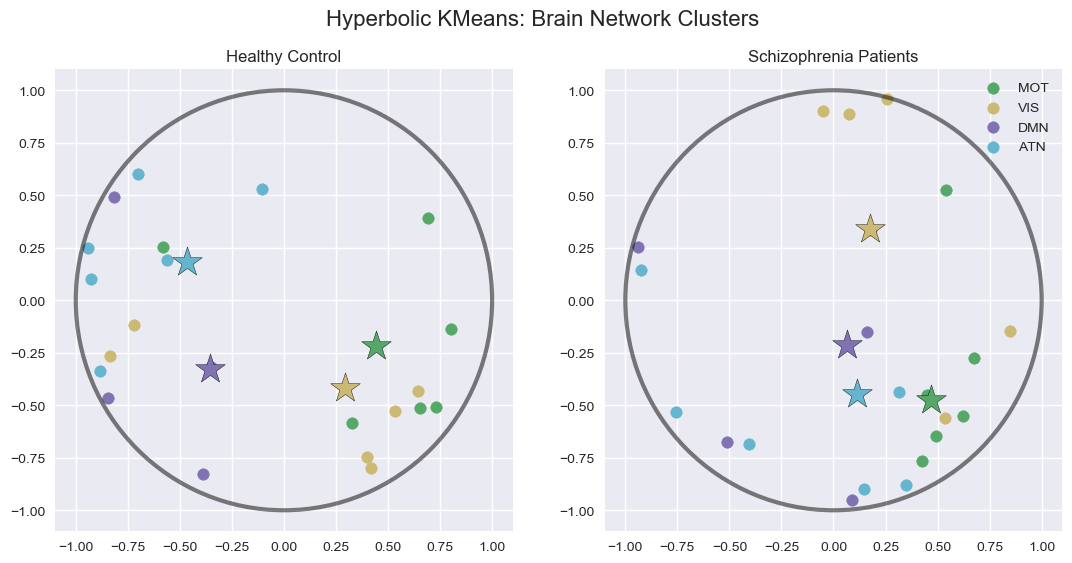

In [613]:
# load embedding and include 4 main sub-networks
clustering_0 = fit_clusters(load_embedding('mean_emb_0.csv'))
emb_0 = clustering_0['embedding']
hkmeans_0 = clustering_0['model']
subnet_labels = {0: 'MOT', 1: 'VIS', 2: 'DMN', 3: 'ATN'}

# plot clustering
plt.figure(figsize=(13,6))
colors = ['g', 'y', 'm', 'c', 'k']

# plot healthy control
plt.subplot(121)
for i in range(len(emb_0.label.unique())):
    plt.scatter(emb_0.loc[(emb_0.label == i), 'x'], emb_0.loc[(emb_0.label == i), 'y'], c=colors[i], s=70, label=subnet_labels[i]);
for i in range(len(emb_0.label.unique())):
    plt.scatter(hkmeans_0.centroids[i][0], hkmeans_0.centroids[i][1], c=colors[i], s=500, marker='*', edgecolor='black');
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.title('Healthy Control')

# apply clustering and plot schizophrenia group
plt.subplot(122)
clustering_1 = fit_clusters(load_embedding('mean_emb_1.csv'), num_updates=5)
emb_1 = clustering_1['embedding']
hkmeans_1 = clustering_1['model']

for i in range(len(emb_1.label.unique())):
    plt.scatter(emb_1.loc[(emb_1.label == i), 'x'], emb_1.loc[(emb_1.label == i), 'y'], c=colors[i], s=70, label=subnet_labels[i]);
for i in range(len(emb_1.label.unique())):
    plt.scatter(hkmeans_1.centroids[i][0], hkmeans_1.centroids[i][1], c=colors[i], s=500, marker='*', edgecolor='black');
    
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.title('Schizophrenia Patients')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1, edgecolor='black');
plt.suptitle('Hyperbolic KMeans: Brain Network Clusters', size=16);
plt.show();

In [614]:
def distance_between(A, B, metric='average'):
    # methods for intercluster distances
    distances = []
    for a in A:
        distances += [poincare_dist(a, b) for b in B]
    if metric == 'average':
        return np.mean(distances)
    elif metric == 'max':
        return np.max(distances)
    elif metric == 'min':
        return np.min(distances)
    else:
        print('Invalid metric specified')
        return
        
def distance_within(A, centroid, metric='variance'):
    # methods to compute cohesion within cluster
    centroid_distances = np.array([poincare_dist(x, centroid) for x in A])
    pairwise_distances = poincare_distances(A)
    if metric == 'variance':
        return np.mean(centroid_distances**2)
    elif metric == 'diameter':
        return np.max(pairwise_distances)
    elif metric == 'pairwise':
        return np.sum(pairwise_distances) / len(A)
    else:
        print('Invalid metric specified')
        return

def cluster_features(emb, centroids, wc_metric='pairwise', bc_metric='average'):
    emb_data = np.array(emb[['x', 'y']])
    within_cluster = []
    between_cluster = []
    for i in range(len(np.unique(emb.label))):
        within_cluster.append(distance_within(emb_data[emb.label == i], centroid=centroids[i], metric=wc_metric))
        for j in range(i+1, len(np.unique(emb.label))):
            between_cluster.append(distance_between(emb_data[emb.label == i], emb_data[emb.label == j], metric=bc_metric))
    return {'within':np.array(within_cluster), 'between': np.array(between_cluster)}

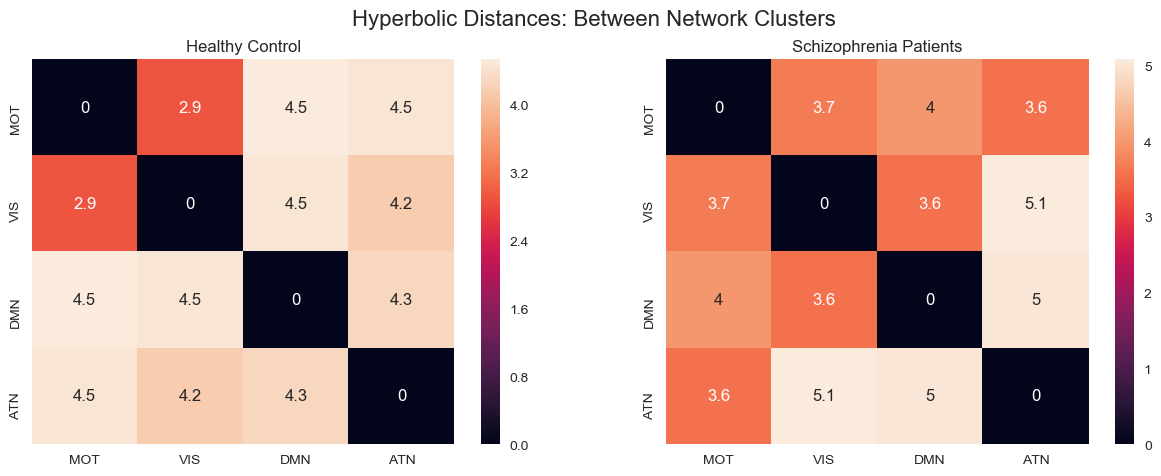

In [615]:
# plot between cluster distance metrics
plt.figure(figsize=(15,5))
plt.subplot(121)
subnet_dist = np.zeros((4,4))
for i in range(4):
    for j in range(i+1, 4):
        subnet_dist[i,j] = cluster_features(emb_0, hkmeans_0.centroids)['between'][i+j-1]
        subnet_dist[j,i] = subnet_dist[i, j]

sns.heatmap(subnet_dist, annot=True);
ax = plt.gca()
ax.set_xticklabels(['MOT', 'VIS', 'DMN', 'ATN'])
ax.set_yticklabels(['MOT', 'VIS', 'DMN', 'ATN'])
plt.title('Healthy Control')

plt.subplot(122)
subnet_dist = np.zeros((4,4))
for i in range(4):
    for j in range(i+1, 4):
        subnet_dist[i,j] = cluster_features(emb_1, hkmeans_1.centroids)['between'][i+j-1]
        subnet_dist[j,i] = subnet_dist[i, j]
        
sns.heatmap(subnet_dist, annot=True);
ax = plt.gca()
ax.set_xticklabels(['MOT', 'VIS', 'DMN', 'ATN'])
ax.set_yticklabels(['MOT', 'VIS', 'DMN', 'ATN'])
plt.title('Schizophrenia Patients')
plt.suptitle('Hyperbolic Distances: Between Network Clusters', size=16)
plt.show();

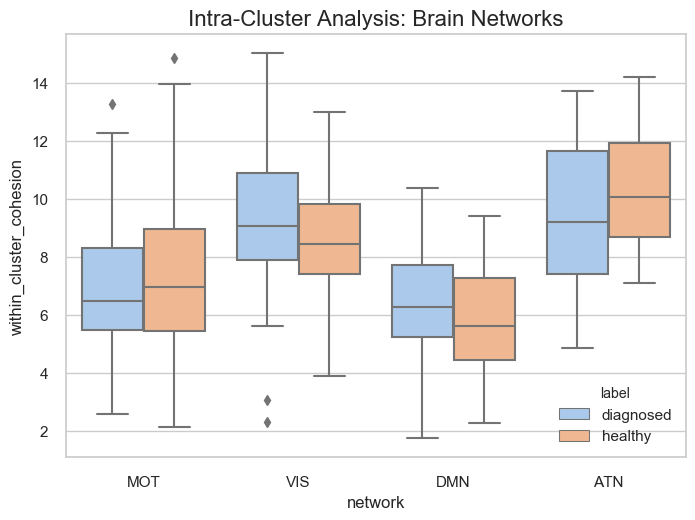

In [616]:
wc_features = []
for i in range(graph_data.shape[0]):
    emb = load_embedding('emb_' + str(i) + '.csv')
    clustering = fit_clusters(emb)
    emb = clustering['embedding']
    hkmeans = clustering['model']
    wc_features.append(cluster_features(emb, hkmeans.centroids)['within'])

eval_cluster = pd.DataFrame(np.ravel(np.array(wc_features)), columns=['within_cluster_cohesion'])
eval_cluster['label'] = np.repeat(graph_labels, 4)
eval_cluster['label'] = eval_cluster.label.apply(lambda x: ['healthy', 'diagnosed'][int(x)])
eval_cluster['network'] = np.tile(['MOT', 'VIS', 'DMN', 'ATN'], 86)
sns.set(style="whitegrid")
ax = sns.boxplot(x="network", y="within_cluster_cohesion", hue="label", data=eval_cluster, palette="pastel")
plt.title('Intra-Cluster Analysis: Brain Networks', size=16)
plt.show();

In [617]:
# get all features from clustering analysis
feature_names = []
wc_features = []
bc_features = []
for i in range(graph_data.shape[0]):
    emb = load_embedding('emb_' + str(i) + '.csv')
    clustering = fit_clusters(emb)
    emb = clustering['embedding']
    hkmeans = clustering['model']
    wc1 = cluster_features(emb, hkmeans.centroids, wc_metric='pairwise')['within']
    wc2 = cluster_features(emb, hkmeans.centroids, wc_metric='variance')['within']
    wc3 = cluster_features(emb, hkmeans.centroids, wc_metric='diameter')['within']
    wc_features.append(np.hstack((wc1, wc2, wc3)))
    bc1 = cluster_features(emb, hkmeans.centroids, bc_metric='average')['between']
    bc2 = cluster_features(emb, hkmeans.centroids, bc_metric='max')['between']
    bc3 = cluster_features(emb, hkmeans.centroids, bc_metric='min')['between']
    bc_features.append(np.hstack((bc1, bc2, bc3)))

# get feature names for analysis
brain_nets = ['MOT', 'VIS', 'DMN', 'ATN']
for metric in ['pairwise', 'variance', 'diameter']:
    for net in brain_nets:
        feature_names.append(metric + '_' + net)
for metric in ['average', 'max', 'min']:
    for i in range(len(brain_nets)):
        for j in range(i+1, len(brain_nets)):
            feature_names.append(metric + '_' + brain_nets[i] + '_' + brain_nets[j])
    
cluster_data_train = np.hstack((np.array(wc_features), np.array(bc_features)))
cluster_data_train.shape

(86, 30)

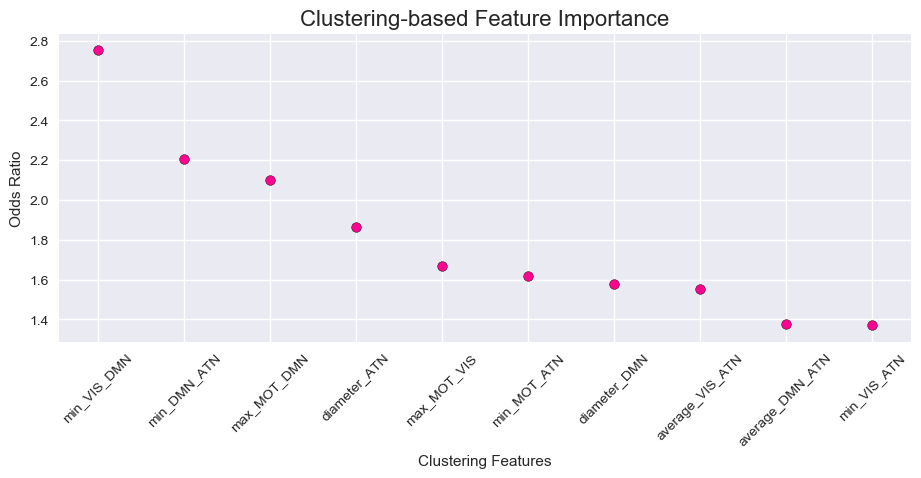

In [620]:
# get top features by odds ratio and visualize group differences
X = cluster_data_train
y = train_labels.Class.values
clf = LogisticRegression(class_weight='balanced')
clf.fit(X, y)
top_ix = np.argsort(-np.exp(clf.coef_[0]))
plt.figure(figsize=(11,4))
plt.style.use('seaborn')
plt.scatter(np.arange(10), -np.sort(-np.exp(clf.coef_[0]))[:10], color="#ff0490", edgecolor='black')
ax = plt.gca()
ax.set_xticks(np.arange(10))
ax.set_xticklabels([feature_names[top_ix[i]] for i in range(10)]);
plt.xticks(rotation=45)
plt.ylabel('Odds Ratio')
plt.xlabel('Clustering Features')
plt.title('Clustering-based Feature Importance', size=16)
plt.show();

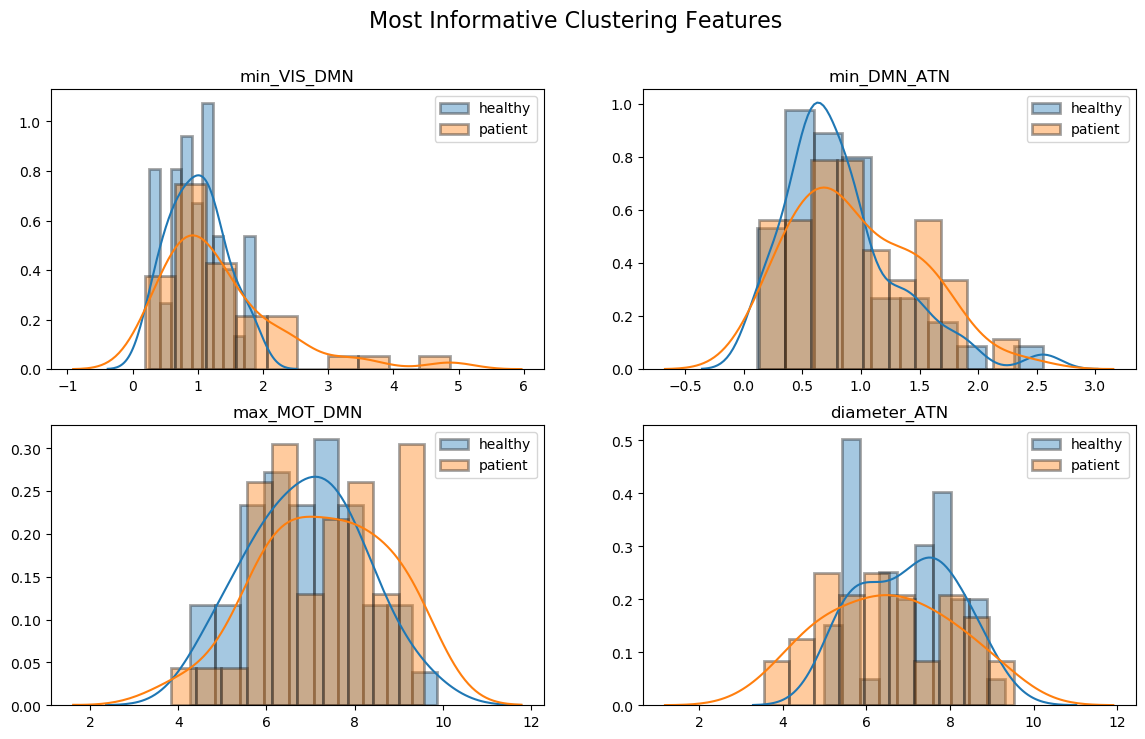

In [625]:
plt.figure(figsize=(14, 8))
plt.style.use('default')
n=4
for i in range(n):
    plt.subplot(2, 2, i+1)
    _ = sns.distplot(X[(y == 0), top_ix[i]], bins=10, hist_kws=dict(edgecolor="k", linewidth=2), label='healthy')
    _ = sns.distplot(X[(y == 1), top_ix[i]], bins=10, hist_kws=dict(edgecolor="k", linewidth=2), label='patient')
    plt.title(feature_names[top_ix[i]]);
    plt.legend();
plt.suptitle('Most Informative Clustering Features', size=16)
plt.show();

In [636]:
# evaluate cross validation metrics
X = cluster_data_train[:, top_ix[:4]]
y = train_labels.Class.values
pred = cross_val_predict(LogisticRegression(class_weight='balanced'), X, y, cv=5)
cluster_f1 = f1_score(y, pred, average='macro')
print(classification_report(y, pred))
print(accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66        46
           1       0.61      0.57      0.59        40

   micro avg       0.63      0.63      0.63        86
   macro avg       0.63      0.62      0.62        86
weighted avg       0.63      0.63      0.63        86

0.627906976744186


With only the top 4 most informative features derived from clustering in the hyperbolic embedding space, the classifier performs almost as well as the model trained on over 300 hyperbolic pairwise distance features, and doesn't do a whole lot worse than the baseline model with 379 FNC features. <br>

Although it doesn't seem our brain networks here are strongly hyperbolic, embedding the brain connectomes into a negatively curved space captured some of the hierarchical relations that exist between sub-networks (such as Default mode network and Attention network in particular). <br>

This higher level analysis seems to provide unique, explanatory insights into larger systemic differences in the neurobiology of Schizophrenics. 

In [637]:
train_data_new = np.hstack((train_data, cluster_data_train[:, top_ix[:4]]))
# evaluate cross validation metrics
X = train_data_new
y = train_labels.Class.values
pred = cross_val_predict(LogisticRegression(class_weight='balanced'), X, y, cv=5)
baseline_cluster_f1 = f1_score(y, pred, average='macro')
print(classification_report(y, pred))
print(accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73        46
           1       0.69      0.72      0.71        40

   micro avg       0.72      0.72      0.72        86
   macro avg       0.72      0.72      0.72        86
weighted avg       0.72      0.72      0.72        86

0.7209302325581395


The classifier trained on the baseline FNC features and the clustering features perfoms significantly better than the baseline alone, suggesting that the hyperbolic clustering approach provided some higher level representations of the larger brain network that couldn't be easily deduced from pairwise correlations alone. 

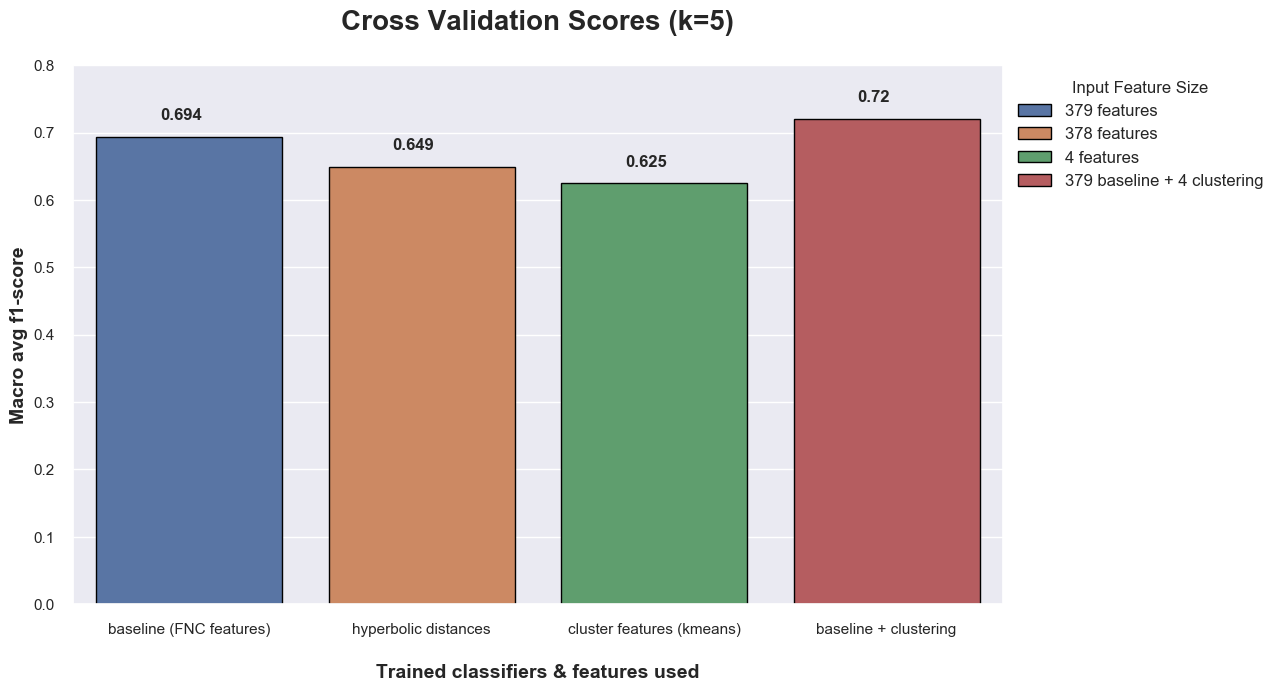

In [731]:
result_df = pd.DataFrame(['baseline (FNC features)', 'hyperbolic distances', 'cluster features (kmeans)', 'baseline + clustering'],
                         columns = ['model'])
f1_scores = np.array([baseline_f1, hyp_f1, cluster_f1, baseline_cluster_f1])
result_df['macro_f1'] = f1_scores
result_df['num_features'] = np.array([379, 378, 4, 383])
plt.figure(figsize=(12,7))
sns.set(style='darkgrid')
plt.rcParams['axes.labelweight'] = 'bold'
ax = sns.barplot(data=result_df, x='model', y='macro_f1', hue='model', dodge=False, ci=None, edgecolor='black', linewidth=1);
ax.set_title('Cross Validation Scores (k=5)', size=20, y=1.05, fontweight='bold')
ax.set_ylabel('Macro avg f1-score', size=14)
ax.set_xlabel('Trained classifiers & features used', size=14, labelpad=20)
plt.ylim([0, 0.8])
# add values onto barplot display
for i, score in enumerate(f1_scores):
    plt.text(i-0.125, score+0.025, str(np.round(score, 3)), fontweight='bold')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ["379 features", "378 features", '4 features', '379 baseline + 4 clustering'],
          fontsize=12, loc='best', bbox_to_anchor=(1, 1), title='Input Feature Size', edgecolor='black');
plt.show();

## Conclusion & Takeaway

* Graph preprocessing and careful integration (unweighted vs. weighted, directed vs. undirected, etc.) with a hyperbolic embedding algorithm is the crucial foundation for any downstream machine learning or data analysis task <br>

* Even if a supervised learning model is not actually training in hyperbolic space (Euclidean logistic regression used here), hyperbolic feature extraction seems promising (especially in brain connectomics where a network can be defined for each observation (row)) <br>

* Hyperbolic KMeans clustering can be used to extract higher level geometric features and characterize sub-network relationships, even with weakly hyperbolic networks with no explicitly defined hierarchical relationships <br>

* In similar graph embedding and network analysis projects, domain expertise likely becomes invaluable when higher level concepts and multi-tiered relationships emerge out of latent geometric relationships (such as the case here where a principally abstract analysis of clustering metrics begins to capture relationships between neurological sub-networks like the Default Mode Network, Attention Network, etc.)    

## Future Investigations

* Brain network datasets based on structural in addition to functional connectomes <br>

* Explore ways to develop a streamlined approach for hyperbolic embeddings and related data/graph processing <br>

* More generalized geometric learning approaches (embedding and also supervised learning) for other non-Euclidean manifolds 